# HPT: PyTorch With VBDP {#sec-vbdp}

In this tutorial, we will show how `spotPython` can be integrated into the `PyTorch`
training workflow for a classifiaction task.

::: {.callout-caution}
### Caution: Data must be downloaded manually

* Ensure that the correspondiing data is available as `./data/VBDP/train.csv`.

:::

This document refers to the following software versions:

- ``python``: 3.10.10
- ``torch``: 2.0.1
- ``torchvision``: 0.15.0


In [1]:
pip list | grep  "spot[RiverPython]"

spotPython                 0.2.41
spotRiver                  0.0.93
Note: you may need to restart the kernel to use updated packages.


`spotPython` can be installed via pip. Alternatively, the source code can be downloaded from gitHub: [https://github.com/sequential-parameter-optimization/spotPython](https://github.com/sequential-parameter-optimization/spotPython).

```{raw}
!pip install spotPython
```

* Uncomment the following lines if you want to for (re-)installation the latest version of `spotPython` from gitHub.

In [2]:
# import sys
# !{sys.executable} -m pip install --upgrade build
# !{sys.executable} -m pip install --upgrade --force-reinstall spotPython

## Step 1: Setup {#sec-setup-25}

Before we consider the detailed experimental setup, we select the parameters that affect run time, initial design size and the device that is used.

::: {.callout-caution}
### Caution: Run time and initial design size should be increased for real experiments

* MAX_TIME is set to one minute for demonstration purposes. For real experiments, this should be increased to at least 1 hour.
* INIT_SIZE is set to 5 for demonstration purposes. For real experiments, this should be increased to at least 10.

:::

::: {.callout-note}
### Note: Device selection

* The device can be selected by setting the variable `DEVICE`.
* Since we are using a simple neural net, the setting `"cpu"` is preferred (on Mac).
* If you have a GPU, you can use `"cuda:0"` instead.
* If DEVICE is set to `None`, `spotPython` will automatically select the device.
  * This might result in `"mps"` on Macs, which is not the best choice for simple neural nets.

:::


In [3]:
MAX_TIME = 1
INIT_SIZE = 5
DEVICE = None, #"cpu" # "cuda:0"

In [4]:
from spotPython.utils.device import getDevice
DEVICE = getDevice(DEVICE)
print(DEVICE)

(None,)


In [5]:
import os
import copy
import socket
from datetime import datetime
from dateutil.tz import tzlocal
start_time = datetime.now(tzlocal())
HOSTNAME = socket.gethostname().split(".")[0]
experiment_name = '30-light' + "_" + HOSTNAME + "_" + str(MAX_TIME) + "min_" + str(INIT_SIZE) + "init_" + str(start_time).split(".", 1)[0].replace(' ', '_')
experiment_name = experiment_name.replace(':', '-')
print(experiment_name)
if not os.path.exists('./figures'):
    os.makedirs('./figures')

30-light_p040025_1min_5init_2023-06-25_20-53-30


## Step 2: Initialization of the `fun_control` Dictionary

:::{.callout-caution}
### Caution: Tensorboard does not work under Windows
* Since tensorboard does not work under Windows, we recommend setting the parameter `tensorboard_path` to `None` if you are working under Windows.
:::

`spotPython` uses a Python dictionary for storing the information required for the hyperparameter tuning process, which was described in @sec-initialization-fun-control-14, see [Initialization of the fun_control Dictionary](https://sequential-parameter-optimization.github.io/spotPython/14_spot_ray_hpt_torch_cifar10.html#sec-initialization-fun-control-14) in the documentation.


In [6]:
from spotPython.utils.init import fun_control_init
fun_control = fun_control_init(task="classification",
    tensorboard_path="./runs/" + experiment_name,
    num_workers=10,
    device=DEVICE)

## Step 3: PyTorch Data Loading {#sec-data-loading-25}

### 1. Load VBDP Data

In [7]:
import torch
from spotPython.light.csvdataset import CSVDataset
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor

# Create an instance of CSVDataset
dataset = CSVDataset(csv_file="./data/VBDP/train.csv", train=True)
# show the dimensions of the dataset
print(dataset[0][0].shape)
# show the first element of the dataset
print(dataset[0][0])

torch.Size([64])
tensor([1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 0., 1., 1., 0., 0.,
        1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


In [8]:
# Create an instance of CSVDataset
dataset = CSVDataset(csv_file="./data/VBDP/train.csv", train=False)
# show the size of the dataset
print(f"Dataset Size: {len(dataset)}")

Dataset Size: 707


In [9]:

# Set batch size for DataLoader
batch_size = 3
# Create DataLoader
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Iterate over the data in the DataLoader
for batch in dataloader:
    inputs, targets = batch
    print(f"Batch Size: {inputs.size(0)}")
    print("---------------")
    print(f"Inputs: {inputs}")
    print(f"Targets: {targets}")
    break


Batch Size: 3
---------------
Inputs: tensor([[1., 1., 1., 1., 0., 1., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1.,
         1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0.,
         0., 1., 0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 1., 1., 1., 0., 0.]])
Targets: tensor([2, 5, 7])


In [10]:
# import pandas as pd
# from sklearn.preprocessing import OrdinalEncoder
# train_df = pd.read_csv('./data/VBDP/train.csv')
# # remove the id column
# train_df = train_df.drop(columns=['id'])
# n_samples = train_df.shape[0]
# n_features = train_df.shape[1] - 1
# target_column = "prognosis"
# # # Encoder our prognosis labels as integers for easier decoding later
# enc = OrdinalEncoder()
# train_df[target_column] = enc.fit_transform(train_df[[target_column]])
# train_df.head()

# # convert all entries to int for faster processing
# train_df = train_df.astype(int)

* Add logical combinations (AND, OR, XOR) of the features to the data set:

In [11]:
# from spotPython.utils.convert import add_logical_columns
# df_new = train_df.copy()
# # save the target column using "target_column" as the column name
# target = train_df[target_column]
# # remove the target column
# df_new = df_new.drop(columns=[target_column])
# train_df = add_logical_columns(df_new)
# # add the target column back
# train_df[target_column] = target
# train_df = train_df.astype(int)
# train_df.head()

In [12]:
# from sklearn.model_selection import train_test_split
# import numpy as np

# n_samples = train_df.shape[0]
# n_features = train_df.shape[1] - 1
# train_df.columns = [f"x{i}" for i in range(1, n_features+1)] + [target_column]
# train_df.head()

### Check content of the target column

In [13]:
# X_train, X_test, y_train, y_test = train_test_split(train_df.drop(target_column, axis=1), train_df[target_column],
#                                                     random_state=42,
#                                                     test_size=0.25,
#                                                     stratify=train_df[target_column])
# trainset = pd.DataFrame(np.hstack((X_train, np.array(y_train).reshape(-1, 1))))
# testset = pd.DataFrame(np.hstack((X_test, np.array(y_test).reshape(-1, 1))))
# trainset.columns = [f"x{i}" for i in range(1, n_features+1)] + [target_column]
# testset.columns = [f"x{i}" for i in range(1, n_features+1)] + [target_column]
# print(train_df.shape)
# print(trainset.shape)
# print(testset.shape)

In [14]:
# import torch
# from sklearn.model_selection import train_test_split
# from spotPython.torch.dataframedataset import DataFrameDataset
# dtype_x = torch.float32
# dtype_y = torch.long
# train_df = DataFrameDataset(train_df, target_column=target_column, dtype_x=dtype_x, dtype_y=dtype_y)
# train = DataFrameDataset(trainset, target_column=target_column, dtype_x=dtype_x, dtype_y=dtype_y)
# test = DataFrameDataset(testset, target_column=target_column, dtype_x=dtype_x, dtype_y=dtype_y)
# n_samples = len(train)
# # add the dataset to the fun_control
# fun_control.update({"data": train_df, # full dataset,
#                "train": trainset,
#                "test": testset,
#                "n_samples": n_samples,
#                "target_column": target_column})

## Step 4: Specification of the Preprocessing Model {#sec-specification-of-preprocessing-model-25}

After the training and test data are specified and added to the `fun_control` dictionary, `spotPython` allows the specification of a data preprocessing pipeline, e.g., for the scaling of the data or for the one-hot encoding of categorical variables, see @sec-specification-of-preprocessing-model-14. This feature is not used here, so we do not change the default value (which is `None`).

## Step 5: Select `algorithm` and `core_model_hyper_dict` {#sec-selection-of-the-algorithm-25}

### Implementing a Configurable Neural Network With spotPython 

`spotPython` includes the `Net_vbdp` class which is implemented in the file `netvbdp.py`.
The class is imported here.

This class  inherits from the class `Net_Core` which is implemented in the file `netcore.py`, see @sec-the-netcore-class-14.

### Add the NN Model to the fun_control Dictionary

In [15]:
from spotPython.light.csvmodel import CSVModel 
from spotPython.data.light_hyper_dict import LightHyperDict
from spotPython.hyperparameters.values import add_core_model_to_fun_control
fun_control = add_core_model_to_fun_control(core_model=CSVModel,
                              fun_control=fun_control,
                              hyper_dict= LightHyperDict)

In [16]:
fun_control["core_model"]

spotPython.light.csvmodel.CSVModel

The corresponding entries for the `core_model` class are shown below.

In [17]:
fun_control['core_model_hyper_dict']

{'l1': {'type': 'int',
  'default': 3,
  'transform': 'transform_power_2_int',
  'lower': 3,
  'upper': 8},
 'epochs': {'type': 'int',
  'default': 4,
  'transform': 'transform_power_2_int',
  'lower': 4,
  'upper': 9},
 'batch_size': {'type': 'int',
  'default': 4,
  'transform': 'transform_power_2_int',
  'lower': 1,
  'upper': 4},
 'act_fn': {'levels': ['ReLU'],
  'type': 'factor',
  'default': 'ReLU',
  'transform': 'None',
  'class_name': 'torch.nn',
  'core_model_parameter_type': 'instance()',
  'lower': 0,
  'upper': 0},
 'optimizer': {'levels': ['Adadelta',
   'Adagrad',
   'Adam',
   'AdamW',
   'SparseAdam',
   'Adamax',
   'ASGD',
   'NAdam',
   'RAdam',
   'RMSprop',
   'Rprop',
   'SGD'],
  'type': 'factor',
  'default': 'SGD',
  'transform': 'None',
  'class_name': 'torch.optim',
  'core_model_parameter_type': 'str',
  'lower': 0,
  'upper': 12},
 'dropout_prob': {'type': 'float',
  'default': 0.01,
  'transform': 'None',
  'lower': 0.0,
  'upper': 0.1}}

## Step 6: Modify `hyper_dict` Hyperparameters for the Selected Algorithm aka `core_model` {#sec-modification-of-hyperparameters-25}

 `spotPython` provides functions for modifying the hyperparameters, their bounds and factors as well as for activating and de-activating hyperparameters without re-compilation of the Python source code. These functions were described in @sec-modification-of-hyperparameters-14.

::: {.callout-caution}
### Caution: Small number of epochs for demonstration purposes

* `epochs` and `patience` are set to small values for demonstration purposes. These values are too small for a real application.
* More resonable values are, e.g.:
  * `fun_control = modify_hyper_parameter_bounds(fun_control, "epochs", bounds=[7, 9])` and
  * `fun_control = modify_hyper_parameter_bounds(fun_control, "patience", bounds=[2, 7])`
:::

In [18]:
from spotPython.hyperparameters.values import modify_hyper_parameter_bounds

fun_control = modify_hyper_parameter_bounds(fun_control, "l1", bounds=[2,3])
fun_control = modify_hyper_parameter_bounds(fun_control, "epochs", bounds=[2,3])
fun_control = modify_hyper_parameter_bounds(fun_control, "batch_size", bounds=[6, 8])

In [19]:
from spotPython.hyperparameters.values import modify_hyper_parameter_levels
fun_control = modify_hyper_parameter_levels(fun_control, "optimizer",["Adam", "AdamW", "Adamax", "NAdam"])
# fun_control = modify_hyper_parameter_levels(fun_control, "optimizer", ["Adam"])
# fun_control["core_model_hyper_dict"]

## Step 7: Selection of the Objective (Loss) Function

### Evaluation  {#sec-selection-of-target-function-25}

The evaluation procedure requires the specification of two elements:

1. the way how the data is split into a train and a test set (see @sec-data-splitting-14)
2. the loss function (and a metric).


### Loss Functions and Metrics {#sec-loss-functions-and-metrics-25}

The loss function is specified by the key `"loss_function"`.
We will use CrossEntropy loss for the multiclass-classification task.

In [20]:
# from torch.nn import CrossEntropyLoss
# loss_function = CrossEntropyLoss()
# fun_control.update({"loss_function": loss_function})

### Metric {#sec-metric-25}

* We will use the MAP@k metric for the evaluation of the model. Here is an example how this metric is calculated.

In [21]:
from spotPython.torch.mapk import MAPK
import torch
mapk = MAPK(k=2)
target = torch.tensor([0, 1, 2, 2])
preds = torch.tensor(
    [
        [0.5, 0.2, 0.2],  # 0 is in top 2
        [0.3, 0.4, 0.2],  # 1 is in top 2
        [0.2, 0.4, 0.3],  # 2 is in top 2
        [0.7, 0.2, 0.1],  # 2 isn't in top 2
    ]
)
mapk.update(preds, target)
print(mapk.compute()) # tensor(0.6250)

tensor(0.6250)


In [22]:
# from spotPython.torch.mapk import MAPK
# import torchmetrics
# metric_torch = MAPK(k=3)
# fun_control.update({"metric_torch": metric_torch})

## Step 8: Calling the SPOT Function

### Preparing the SPOT Call {#sec-prepare-spot-call-25}

The following code passes the information about the parameter ranges and bounds to `spot`.

In [23]:
# extract the variable types, names, and bounds
from spotPython.hyperparameters.values import (get_bound_values,
    get_var_name,
    get_var_type,)
var_type = get_var_type(fun_control)
var_name = get_var_name(fun_control)
fun_control.update({"var_type": var_type,
                    "var_name": var_name})
lower = get_bound_values(fun_control, "lower")
upper = get_bound_values(fun_control, "upper")

Now, the dictionary `fun_control` contains all information needed for the hyperparameter tuning. Before the hyperparameter tuning is started, it is recommended to take a look at the experimental design. The method `gen_design_table` generates a design table as follows:

In [24]:
#| fig-cap: Experimental design for the hyperparameter tuning.
from spotPython.utils.eda import gen_design_table
print(gen_design_table(fun_control))

| name         | type   | default   |   lower |   upper | transform             |
|--------------|--------|-----------|---------|---------|-----------------------|
| l1           | int    | 3         |       2 |     3   | transform_power_2_int |
| epochs       | int    | 4         |       2 |     3   | transform_power_2_int |
| batch_size   | int    | 4         |       6 |     8   | transform_power_2_int |
| act_fn       | factor | ReLU      |       0 |     0   | None                  |
| optimizer    | factor | SGD       |       0 |     3   | None                  |
| dropout_prob | float  | 0.01      |       0 |     0.1 | None                  |


This allows to check if all information is available and if the information is correct.

### The Objective Function `fun_torch` {#sec-the-objective-function-25}

The objective function `fun_torch` is selected next. It implements an interface from `PyTorch`'s training, validation, and  testing methods to `spotPython`.


In [25]:
from spotPython.light.hyperlight import HyperLight
fun = HyperLight().fun

In [26]:
from spotPython.hyperparameters.values import get_default_hyperparameters_as_array
hyper_dict=LightHyperDict().load()
X_start = get_default_hyperparameters_as_array(fun_control, hyper_dict)
X_start

array([[3.0e+00, 4.0e+00, 4.0e+00, 0.0e+00, 1.1e+01, 1.0e-02]])

In [27]:
fun_control["tensorboard_path"]

'./runs/30-light_p040025_1min_5init_2023-06-25_20-53-30'

### Starting the Hyperparameter Tuning {#sec-call-the-hyperparameter-tuner-25}

The `spotPython` hyperparameter tuning is started by calling the `Spot` function as described in @sec-call-the-hyperparameter-tuner-14.


In [28]:
import numpy as np
from spotPython.spot import spot
from math import inf
spot_tuner = spot.Spot(fun=fun,
                   lower = lower,
                   upper = upper,
                   fun_evals = inf,
                   fun_repeats = 1,
                   max_time = MAX_TIME,
                   noise = False,
                   tolerance_x = np.sqrt(np.spacing(1)),
                   var_type = var_type,
                   var_name = var_name,
                   infill_criterion = "y",
                   n_points = 1,
                   seed=123,
                   log_level = 50,
                   show_models= False,
                   show_progress= True,
                   fun_control = fun_control,
                   design_control={"init_size": INIT_SIZE,
                                   "repeats": 1},
                   surrogate_control={"noise": True,
                                      "cod_type": "norm",
                                      "min_theta": -4,
                                      "max_theta": 3,
                                      "n_theta": len(var_name),
                                      "model_fun_evals": 10_000,
                                      "log_level": 50
                                      })
spot_tuner.run(X_start=X_start)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name       | Type       | Params
------------------------------------------
0 | act_fn     | ReLU       | 0     
1 | train_mapk | MAPK       | 0     
2 | valid_mapk | MAPK       | 0     
3 | test_mapk  | MAPK       | 0     
4 | model      | Sequential | 619   
------------------------------------------
619       Trainable params
0         Non-trainable params
619       Total params
0.002     Total estimated model params size (MB)



config: {'l1': 8, 'epochs': 4, 'batch_size': 256, 'act_fn': ReLU(), 'optimizer': 'Adamax', 'dropout_prob': 0.036481881978299394}
model: CSVModel(
  (act_fn): ReLU()
  (train_mapk): MAPK()
  (valid_mapk): MAPK()
  (test_mapk): MAPK()
  (model): Sequential(
    (0): Linear(in_features=64, out_features=8, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.036481881978299394, inplace=False)
    (3): Linear(in_features=8, out_features=4, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.036481881978299394, inplace=False)
    (6): Linear(in_features=4, out_features=4, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.036481881978299394, inplace=False)
    (9): Linear(in_features=4, out_features=2, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.036481881978299394, inplace=False)
    (12): Linear(in_features=2, out_features=11, bias=True)
  )
)


Sanity Checking: 0it [00:00, ?it/s]

/Users/bartz/miniforge3/envs/spotCondaEnv/lib/python3.10/site-packages/torch/functional.py:791: UserWarning: The operator 'aten::_unique2' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:11.)
  output, inverse_indices, counts = torch._unique2(
/Users/bartz/miniforge3/envs/spotCondaEnv/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (2) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=4` reached.


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.08480565249919891    │
│         val_loss          │    2.3962504863739014     │
│        valid_mapk         │    0.18746381998062134    │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name       | Type       | Params
------------------------------------------
0 | act_fn     | ReLU       | 0     
1 | train_mapk | MAPK       | 0     
2 | valid_mapk | MAPK       | 0     
3 | test_mapk  | MAPK       | 0     
4 | model      | Sequential | 301   
------------------------------------------
301       Trainable params
0         Non-trainable params
301       Total params
0.001     Total estimated model params size (MB)


train_model result: {'valid_mapk': 0.18746381998062134, 'val_loss': 2.3962504863739014, 'val_acc': 0.08480565249919891}

config: {'l1': 4, 'epochs': 4, 'batch_size': 128, 'act_fn': ReLU(), 'optimizer': 'Adam', 'dropout_prob': 0.06220214613777628}
model: CSVModel(
  (act_fn): ReLU()
  (train_mapk): MAPK()
  (valid_mapk): MAPK()
  (test_mapk): MAPK()
  (model): Sequential(
    (0): Linear(in_features=64, out_features=4, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.06220214613777628, inplace=False)
    (3): Linear(in_features=4, out_features=2, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.06220214613777628, inplace=False)
    (6): Linear(in_features=2, out_features=2, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.06220214613777628, inplace=False)
    (9): Linear(in_features=2, out_features=1, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.06220214613777628, inplace=False)
    (12): Linear(in_features=1, out_features=11, bias=True)
  )
)


Sanity Checking: 0it [00:00, ?it/s]

/Users/bartz/miniforge3/envs/spotCondaEnv/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=4` reached.


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.10247349739074707    │
│         val_loss          │     2.403378486633301     │
│        valid_mapk         │    0.15573559701442719    │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name       | Type       | Params
------------------------------------------
0 | act_fn     | ReLU       | 0     
1 | train_mapk | MAPK       | 0     
2 | valid_mapk | MAPK       | 0     
3 | test_mapk  | MAPK       | 0     
4 | model      | Sequential | 619   
------------------------------------------
619       Trainable params
0         Non-trainable params
619       Total params
0.002     Total estimated model params size (MB)


train_model result: {'valid_mapk': 0.15573559701442719, 'val_loss': 2.403378486633301, 'val_acc': 0.10247349739074707}

config: {'l1': 8, 'epochs': 8, 'batch_size': 64, 'act_fn': ReLU(), 'optimizer': 'Adamax', 'dropout_prob': 0.0851706589553058}
model: CSVModel(
  (act_fn): ReLU()
  (train_mapk): MAPK()
  (valid_mapk): MAPK()
  (test_mapk): MAPK()
  (model): Sequential(
    (0): Linear(in_features=64, out_features=8, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.0851706589553058, inplace=False)
    (3): Linear(in_features=8, out_features=4, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.0851706589553058, inplace=False)
    (6): Linear(in_features=4, out_features=4, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.0851706589553058, inplace=False)
    (9): Linear(in_features=4, out_features=2, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.0851706589553058, inplace=False)
    (12): Linear(in_features=2, out_features=11, bias=True)
  )
)


Sanity Checking: 0it [00:00, ?it/s]

/Users/bartz/miniforge3/envs/spotCondaEnv/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (7) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=8` reached.


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.14134275913238525    │
│         val_loss          │     2.394498348236084     │
│        valid_mapk         │    0.20883488655090332    │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name       | Type       | Params
------------------------------------------
0 | act_fn     | ReLU       | 0     
1 | train_mapk | MAPK       | 0     
2 | valid_mapk | MAPK       | 0     
3 | test_mapk  | MAPK       | 0     
4 | model      | Sequential | 301   
------------------------------------------
301       Trainable params
0         Non-trainable params
301       Total params
0.001     Total estimated model params size (MB)


train_model result: {'valid_mapk': 0.20883488655090332, 'val_loss': 2.394498348236084, 'val_acc': 0.14134275913238525}

config: {'l1': 4, 'epochs': 4, 'batch_size': 128, 'act_fn': ReLU(), 'optimizer': 'AdamW', 'dropout_prob': 0.04963669926294571}
model: CSVModel(
  (act_fn): ReLU()
  (train_mapk): MAPK()
  (valid_mapk): MAPK()
  (test_mapk): MAPK()
  (model): Sequential(
    (0): Linear(in_features=64, out_features=4, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.04963669926294571, inplace=False)
    (3): Linear(in_features=4, out_features=2, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.04963669926294571, inplace=False)
    (6): Linear(in_features=2, out_features=2, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.04963669926294571, inplace=False)
    (9): Linear(in_features=2, out_features=1, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.04963669926294571, inplace=False)
    (12): Linear(in_features=1, out_features=11, bias=True)
  )
)


Sanity Checking: 0it [00:00, ?it/s]

/Users/bartz/miniforge3/envs/spotCondaEnv/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=4` reached.


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.06713780760765076    │
│         val_loss          │    2.4025814533233643     │
│        valid_mapk         │    0.16456083953380585    │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name       | Type       | Params
------------------------------------------
0 | act_fn     | ReLU       | 0     
1 | train_mapk | MAPK       | 0     
2 | valid_mapk | MAPK       | 0     
3 | test_mapk  | MAPK       | 0     
4 | model      | Sequential | 619   
------------------------------------------
619       Trainable params
0         Non-trainable params
619       Total params
0.002     Total estimated model params size (MB)


train_model result: {'valid_mapk': 0.16456083953380585, 'val_loss': 2.4025814533233643, 'val_acc': 0.06713780760765076}

config: {'l1': 8, 'epochs': 8, 'batch_size': 128, 'act_fn': ReLU(), 'optimizer': 'NAdam', 'dropout_prob': 0.016313240251430407}
model: CSVModel(
  (act_fn): ReLU()
  (train_mapk): MAPK()
  (valid_mapk): MAPK()
  (test_mapk): MAPK()
  (model): Sequential(
    (0): Linear(in_features=64, out_features=8, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.016313240251430407, inplace=False)
    (3): Linear(in_features=8, out_features=4, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.016313240251430407, inplace=False)
    (6): Linear(in_features=4, out_features=4, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.016313240251430407, inplace=False)
    (9): Linear(in_features=4, out_features=2, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.016313240251430407, inplace=False)
    (12): Linear(in_features=2, out_features=11, bias=True)
  )
)


Sanity Checking: 0it [00:00, ?it/s]

/Users/bartz/miniforge3/envs/spotCondaEnv/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (4) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=8` reached.


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.0989399328827858     │
│         val_loss          │     2.397491216659546     │
│        valid_mapk         │    0.15670010447502136    │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name       | Type       | Params
------------------------------------------
0 | act_fn     | ReLU       | 0     
1 | train_mapk | MAPK       | 0     
2 | valid_mapk | MAPK       | 0     
3 | test_mapk  | MAPK       | 0     
4 | model      | Sequential | 619   
------------------------------------------
619       Trainable params
0         Non-trainable params
619       Total params
0.002     Total estimated model params size (MB)


train_model result: {'valid_mapk': 0.15670010447502136, 'val_loss': 2.397491216659546, 'val_acc': 0.0989399328827858}

config: {'l1': 8, 'epochs': 8, 'batch_size': 64, 'act_fn': ReLU(), 'optimizer': 'Adamax', 'dropout_prob': 0.0972927880604052}
model: CSVModel(
  (act_fn): ReLU()
  (train_mapk): MAPK()
  (valid_mapk): MAPK()
  (test_mapk): MAPK()
  (model): Sequential(
    (0): Linear(in_features=64, out_features=8, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.0972927880604052, inplace=False)
    (3): Linear(in_features=8, out_features=4, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.0972927880604052, inplace=False)
    (6): Linear(in_features=4, out_features=4, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.0972927880604052, inplace=False)
    (9): Linear(in_features=4, out_features=2, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.0972927880604052, inplace=False)
    (12): Linear(in_features=2, out_features=11, bias=True)
  )
)


Sanity Checking: 0it [00:00, ?it/s]

/Users/bartz/miniforge3/envs/spotCondaEnv/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (7) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=8` reached.


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.11660777032375336    │
│         val_loss          │    2.3966641426086426     │
│        valid_mapk         │    0.18975694477558136    │
└───────────────────────────┴───────────────────────────┘

train_model result: {'valid_mapk': 0.18975694477558136, 'val_loss': 2.3966641426086426, 'val_acc': 0.11660777032375336}
spotPython tuning: 2.394498348236084 [########--] 83.76% 


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name       | Type       | Params
------------------------------------------
0 | act_fn     | ReLU       | 0     
1 | train_mapk | MAPK       | 0     
2 | valid_mapk | MAPK       | 0     
3 | test_mapk  | MAPK       | 0     
4 | model      | Sequential | 619   
------------------------------------------
619       Trainable params
0         Non-trainable params
619       Total params
0.002     Total estimated model params size (MB)



config: {'l1': 8, 'epochs': 8, 'batch_size': 64, 'act_fn': ReLU(), 'optimizer': 'Adamax', 'dropout_prob': 0.0889510267246861}
model: CSVModel(
  (act_fn): ReLU()
  (train_mapk): MAPK()
  (valid_mapk): MAPK()
  (test_mapk): MAPK()
  (model): Sequential(
    (0): Linear(in_features=64, out_features=8, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.0889510267246861, inplace=False)
    (3): Linear(in_features=8, out_features=4, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.0889510267246861, inplace=False)
    (6): Linear(in_features=4, out_features=4, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.0889510267246861, inplace=False)
    (9): Linear(in_features=4, out_features=2, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.0889510267246861, inplace=False)
    (12): Linear(in_features=2, out_features=11, bias=True)
  )
)


Sanity Checking: 0it [00:00, ?it/s]

/Users/bartz/miniforge3/envs/spotCondaEnv/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (7) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=8` reached.


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.10247349739074707    │
│         val_loss          │    2.3995134830474854     │
│        valid_mapk         │    0.14444445073604584    │
└───────────────────────────┴───────────────────────────┘

train_model result: {'valid_mapk': 0.14444445073604584, 'val_loss': 2.3995134830474854, 'val_acc': 0.10247349739074707}
spotPython tuning: 2.394498348236084 [##########] 100.00% Done...



## Step 9: Tensorboard {#sec-tensorboard-25}

The textual output shown in the console (or code cell) can be visualized with Tensorboard as described in @sec-tensorboard-14, see also the description in the documentation: [Tensorboard.](https://sequential-parameter-optimization.github.io/spotPython/14_spot_ray_hpt_torch_cifar10.html#sec-tensorboard-14)

## Step 10: Results {#sec-results-25}

After the hyperparameter tuning run is finished, the results can be analyzed as described in @sec-results-14.

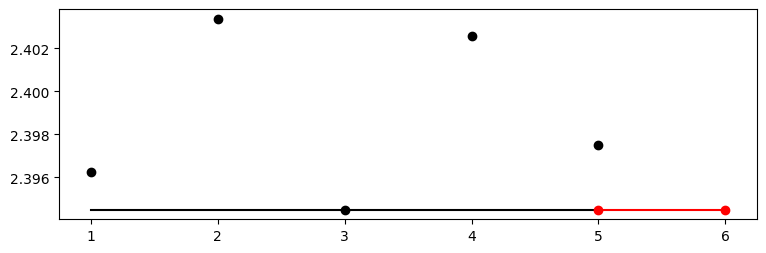

In [29]:
#| fig-cap: Progress plot. *Black* dots denote results from the initial design. *Red* dots  illustrate the improvement found by the surrogate model based optimization.
spot_tuner.plot_progress(log_y=False, 
    filename="./figures/" + experiment_name+"_progress.png")

In [30]:
#| fig-cap: Results of the hyperparameter tuning.
from spotPython.utils.eda import gen_design_table
print(gen_design_table(fun_control=fun_control, spot=spot_tuner))

| name         | type   | default   |   lower |   upper |              tuned | transform             |   importance | stars   |
|--------------|--------|-----------|---------|---------|--------------------|-----------------------|--------------|---------|
| l1           | int    | 3         |     2.0 |     3.0 |                3.0 | transform_power_2_int |       100.00 | ***     |
| epochs       | int    | 4         |     2.0 |     3.0 |                3.0 | transform_power_2_int |         0.00 |         |
| batch_size   | int    | 4         |     6.0 |     8.0 |                6.0 | transform_power_2_int |         0.00 |         |
| act_fn       | factor | ReLU      |     0.0 |     0.0 |                0.0 | None                  |         0.00 |         |
| optimizer    | factor | SGD       |     0.0 |     3.0 |                2.0 | None                  |         0.01 |         |
| dropout_prob | float  | 0.01      |     0.0 |     0.1 | 0.0851706589553058 | None                  |  

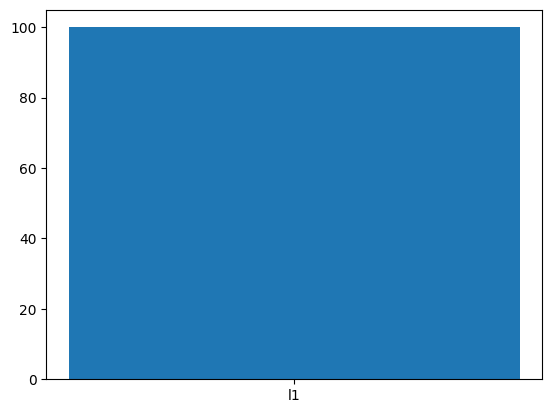

In [31]:
#| fig-cap: 'Variable importance plot, threshold 0.025.'
spot_tuner.plot_importance(threshold=0.025,
    filename="./figures/" + experiment_name+"_importance.png")

# Get the Data Without Lightning

In [32]:
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder
train_df = pd.read_csv('./data/VBDP/train.csv')
# remove the id column
train_df = train_df.drop(columns=['id'])
n_samples = train_df.shape[0]
n_features = train_df.shape[1] - 1
target_column = "prognosis"
# # Encoder our prognosis labels as integers for easier decoding later
enc = OrdinalEncoder()
train_df[target_column] = enc.fit_transform(train_df[[target_column]])
train_df.head()

# convert all entries to int for faster processing
train_df = train_df.astype(int)
from sklearn.model_selection import train_test_split
import numpy as np

n_samples = train_df.shape[0]
n_features = train_df.shape[1] - 1
train_df.columns = [f"x{i}" for i in range(1, n_features+1)] + [target_column]
train_df.head()
X_train, X_test, y_train, y_test = train_test_split(train_df.drop(target_column, axis=1), train_df[target_column],
                                                    random_state=42,
                                                    test_size=0.25,
                                                    stratify=train_df[target_column])
trainset = pd.DataFrame(np.hstack((X_train, np.array(y_train).reshape(-1, 1))))
testset = pd.DataFrame(np.hstack((X_test, np.array(y_test).reshape(-1, 1))))
trainset.columns = [f"x{i}" for i in range(1, n_features+1)] + [target_column]
testset.columns = [f"x{i}" for i in range(1, n_features+1)] + [target_column]
print(train_df.shape)
print(trainset.shape)
print(testset.shape)
import torch
from sklearn.model_selection import train_test_split
from spotPython.torch.dataframedataset import DataFrameDataset
dtype_x = torch.float32
dtype_y = torch.long
train_df = DataFrameDataset(train_df, target_column=target_column, dtype_x=dtype_x, dtype_y=dtype_y)
train = DataFrameDataset(trainset, target_column=target_column, dtype_x=dtype_x, dtype_y=dtype_y)
test = DataFrameDataset(testset, target_column=target_column, dtype_x=dtype_x, dtype_y=dtype_y)
n_samples = len(train)
# add the dataset to the fun_control
fun_control.update({"data": train_df, # full dataset,
               "train": trainset,
               "test": testset,
               "n_samples": n_samples,
               "target_column": target_column})

(707, 65)
(530, 65)
(177, 65)


### Get the Tuned Architecture {#sec-get-spot-results-25}

In [33]:
from spotPython.hyperparameters.values import get_one_config_from_X
X = spot_tuner.to_all_dim(spot_tuner.min_X.reshape(1,-1))
config = get_one_config_from_X(X, fun_control)
config

{'l1': 8,
 'epochs': 8,
 'batch_size': 64,
 'act_fn': ReLU(),
 'optimizer': 'Adamax',
 'dropout_prob': 0.0851706589553058}

In [34]:
from spotPython.light.traintest import test_model
test_model(config, fun_control)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/bartz/miniforge3/envs/spotCondaEnv/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:615: UserWarning: Checkpoint directory ./runs/30-light_p040025_1min_5init_2023-06-25_20-53-30/lightning_logs/8_8_64_ReLU()_Adamax_0.0851706589553058/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name       | Type       | Params
------------------------------------------
0 | act_fn     | ReLU       | 0     
1 | train_mapk | MAPK       | 0     
2 | valid_mapk | MAPK       | 0     
3 | test_mapk  | MAPK       | 0     
4 | model      | Sequential | 619   
------------------------------------------
619       Trainable params
0         Non-trainable params
619       Total params
0.002     Total estimated model params size (MB)


model: CSVModel(
  (act_fn): ReLU()
  (train_mapk): MAPK()
  (valid_mapk): MAPK()
  (test_mapk): MAPK()
  (model): Sequential(
    (0): Linear(in_features=64, out_features=8, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.0851706589553058, inplace=False)
    (3): Linear(in_features=8, out_features=4, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.0851706589553058, inplace=False)
    (6): Linear(in_features=4, out_features=4, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.0851706589553058, inplace=False)
    (9): Linear(in_features=4, out_features=2, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.0851706589553058, inplace=False)
    (12): Linear(in_features=2, out_features=11, bias=True)
  )
)


Sanity Checking: 0it [00:00, ?it/s]

/Users/bartz/miniforge3/envs/spotCondaEnv/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (7) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=8` reached.
/Users/bartz/miniforge3/envs/spotCondaEnv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:189: UserWarning: .test(ckpt_path="last") is set, but there is no last checkpoint available. No checkpoint will be loaded.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_mapk_epoch      │    0.1673177033662796     │
│          val_acc          │    0.09900990128517151    │
│         val_loss          │    2.3972184658050537     │
└───────────────────────────┴───────────────────────────┘

test_model result: {'test_mapk_epoch': 0.1673177033662796, 'val_loss': 2.3972184658050537, 'val_acc': 0.09900990128517151}


(2.3972184658050537, 0.09900990128517151)

# Cross Validation With Lightning

In [35]:
from spotPython.light.traintest import cv_model
cv_model(config, fun_control)

model: CSVModel(
  (act_fn): ReLU()
  (train_mapk): MAPK()
  (valid_mapk): MAPK()
  (test_mapk): MAPK()
  (model): Sequential(
    (0): Linear(in_features=64, out_features=8, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.0851706589553058, inplace=False)
    (3): Linear(in_features=8, out_features=4, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.0851706589553058, inplace=False)
    (6): Linear(in_features=4, out_features=4, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.0851706589553058, inplace=False)
    (9): Linear(in_features=4, out_features=2, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.0851706589553058, inplace=False)
    (12): Linear(in_features=2, out_features=11, bias=True)
  )
)


TypeError: KFoldDataModule.__init__() got an unexpected keyword argument 'num_folds'

# END

In [ ]:
from spotPython.light.kfolddatamodule import KFoldDataModule
import lightning as L
results = []
nums_folds = 10
split_seed = 12345

for k in range(nums_folds):
    dm = KFoldDataModule(k=k, num_folds=num_folds, split_seed=split_seed)
    dm.prepare_data()
    dm.setup()

    # here we train the model on given split...
    print(f"model: {model}")
    # Init trainer
    trainer = L.Trainer(
        max_epochs=model.epochs,
        accelerator="auto",
        devices=1,
        # logger=TensorBoardLogger(save_dir=fun_control["tensorboard_path"], version=config_id),
    )
    # Pass the datamodule as arg to trainer.fit to override model hooks :)
    trainer.fit(model=model, datamodule=dm)
    # Test best model on validation and test set
    # result = trainer.validate(model=model, datamodule=dm, ckpt_path="last")
    score = trainer.validate(model=model, datamodule=dm)
    # unlist the result (from a list of one dict)
    score = score[0]
    print(f"train_model result: {score}")

    results.append(score)

score = sum(results) / num_folds

## Evaluation of the Tuned Architecture Without Lightning

In [ ]:
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder
train_df = pd.read_csv('./data/VBDP/train.csv')
# remove the id column
train_df = train_df.drop(columns=['id'])
n_samples = train_df.shape[0]
n_features = train_df.shape[1] - 1
target_column = "prognosis"
# # Encoder our prognosis labels as integers for easier decoding later
enc = OrdinalEncoder()
train_df[target_column] = enc.fit_transform(train_df[[target_column]])
train_df.head()

# convert all entries to int for faster processing
train_df = train_df.astype(int)
from sklearn.model_selection import train_test_split
import numpy as np

n_samples = train_df.shape[0]
n_features = train_df.shape[1] - 1
train_df.columns = [f"x{i}" for i in range(1, n_features+1)] + [target_column]
train_df.head()
X_train, X_test, y_train, y_test = train_test_split(train_df.drop(target_column, axis=1), train_df[target_column],
                                                    random_state=42,
                                                    test_size=0.25,
                                                    stratify=train_df[target_column])
trainset = pd.DataFrame(np.hstack((X_train, np.array(y_train).reshape(-1, 1))))
testset = pd.DataFrame(np.hstack((X_test, np.array(y_test).reshape(-1, 1))))
trainset.columns = [f"x{i}" for i in range(1, n_features+1)] + [target_column]
testset.columns = [f"x{i}" for i in range(1, n_features+1)] + [target_column]
print(train_df.shape)
print(trainset.shape)
print(testset.shape)
import torch
from sklearn.model_selection import train_test_split
from spotPython.torch.dataframedataset import DataFrameDataset
dtype_x = torch.float32
dtype_y = torch.long
train_df = DataFrameDataset(train_df, target_column=target_column, dtype_x=dtype_x, dtype_y=dtype_y)
train = DataFrameDataset(trainset, target_column=target_column, dtype_x=dtype_x, dtype_y=dtype_y)
test = DataFrameDataset(testset, target_column=target_column, dtype_x=dtype_x, dtype_y=dtype_y)
n_samples = len(train)
# add the dataset to the fun_control
fun_control.update({"data": train_df, # full dataset,
               "train": trainset,
               "test": testset,
               "n_samples": n_samples,
               "target_column": target_column})

In [ ]:
from spotPython.hyperparameters.values import get_one_core_model_from_X
X = spot_tuner.to_all_dim(spot_tuner.min_X.reshape(1,-1))
model_spot = get_one_core_model_from_X(X, fun_control)
model_spot

In [ ]:
from spotPython.torch.traintest import (
    train_tuned,
    test_tuned,
    )
train_tuned(net=model_spot, train_dataset=train,
        loss_function=fun_control["loss_function"],
        metric=fun_control["metric_torch"],
        shuffle=True,
        device = fun_control["device"],
        path=None,
        task=fun_control["task"],)

If `path` is set to a filename, e.g., `path = "model_spot_trained.pt"`, the weights of the trained model will be loaded from this file.

In [ ]:
test_tuned(net=model_spot, test_dataset=test,
            shuffle=False,
            loss_function=fun_control["loss_function"],
            metric=fun_control["metric_torch"],
            device = fun_control["device"],
            task=fun_control["task"],)

### Cross-validated Evaluations

* This is the evaluation that will be used in the comparison.

::: {.callout-caution}
### Caution: Cross-validated Evaluations

* The number of folds is set to 1 by default.
* Here it was changed to 3 for demonstration purposes.
* Set the number of folds to a reasonable value, e.g., 10.
* This can be done by setting the `k_folds` attribute of the model as follows:
* `setattr(model_spot, "k_folds",  10)`
:::

In [ ]:
from spotPython.torch.traintest import evaluate_cv
# modify k-kolds:
setattr(model_spot, "k_folds",  3)
df_eval, df_preds, df_metrics = evaluate_cv(net=model_spot,
    dataset=fun_control["data"],
    loss_function=fun_control["loss_function"],
    metric=fun_control["metric_torch"],
    task=fun_control["task"],
    writer=fun_control["writer"],
    writerId="model_spot_cv",
    device = fun_control["device"])

In [ ]:
metric_name = type(fun_control["metric_torch"]).__name__
print(f"loss: {df_eval}, Cross-validated {metric_name}: {df_metrics}")

### Detailed Hyperparameter Plots

In [ ]:
#| fig-cap: Contour plots.
filename = "./figures/" + experiment_name
spot_tuner.plot_important_hyperparameter_contour(filename=filename)

### Parallel Coordinates Plot

In [ ]:
#| fig-cap: Parallel coordinates plots
spot_tuner.parallel_plot()

### Plot all Combinations of Hyperparameters

* Warning: this may take a while.

In [ ]:
PLOT_ALL = False
if PLOT_ALL:
    n = spot_tuner.k
    for i in range(n-1):
        for j in range(i+1, n):
            spot_tuner.plot_contour(i=i, j=j, min_z=min_z, max_z = max_z)